# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-3, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.weights = None
        self.means = None
        self.covars = None
        self.converged = False

    def initialize_parameters(self, X):
        np.random.seed(1)
        n_samples, n_features = X.shape

        self.means = X[np.random.choice(n_samples, self.n_components, False), :]

        self.weights = np.full(self.n_components, 1 / self.n_components)

        self.covars = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for i, (mean, covar) in enumerate(zip(self.means, self.covars)):
            rv = multivariate_normal(mean, covar)
            responsibilities[:, i] = self.weights[i] * rv.pdf(X)

        responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= responsibilities_sum

        return responsibilities

    def m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        weights = responsibilities.sum(axis=0)
        weighted_sum = np.dot(responsibilities.T, X)
        means = weighted_sum / weights[:, np.newaxis]
        covars = np.zeros((self.n_components, n_features, n_features))

        for i in range(self.n_components):
            diff = X - means[i]
            weighted_sum = np.dot(responsibilities[:, i] * diff.T, diff)
            covar = weighted_sum / weights[i]
            # Add a small regularization term to the diagonal of the covariance matrix
            covars[i] = covar + np.eye(n_features) * self.reg_covar

        self.weights = weights / n_samples
        self.means = means
        self.covars = covars


    def fit(self, X):
        self.initialize_parameters(X)

        for _ in range(self.max_iter):
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)

            log_likelihood = np.sum(np.log(np.sum([w * multivariate_normal(mean, covar).pdf(X)
                                                   for w, mean, covar in zip(self.weights, self.means, self.covars)], axis=0)))
            if log_likelihood > -self.tol:
                self.converged = True
                break

    def predict_proba(self, X):
        likelihood = np.array([multivariate_normal(mean, covar).pdf(X)
                               for mean, covar in zip(self.means, self.covars)])
        probabilities = np.dot(likelihood.T, self.weights)
        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [3]:
video = 'traffic.gif'

source_path = f'./{video}'

In [4]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [5]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [6]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [7]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [8]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

In [11]:
import imageio
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

video = 'traffic.gif'
source_path = f'./{video}'

gif = imageio.mimread(source_path)

frames = [cv2.cvtColor(np.asarray(frame), cv2.COLOR_BGR2RGB).astype(np.float64) / 255.0 for frame in gif]

frames_np = np.array(frames)

train_frames, test_frames = train_test_split(frames_np, train_size=0.6, shuffle=False)

print(f'frame: {frames_np.shape}')
print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')


frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


#### Frame Averaging

Extract Background Image from the training data and display it.

In [12]:
import imageio

In [13]:


source_path = 'traffic.gif'

frames = imageio.mimread(source_path)

background_image_avg = np.mean(train_frames, axis=0)

background_image_avg_uint8 = (background_image_avg * 255).astype(np.uint8)

background_image_path = 'background_image_avg.png'
imageio.imwrite(background_image_path, background_image_avg_uint8)



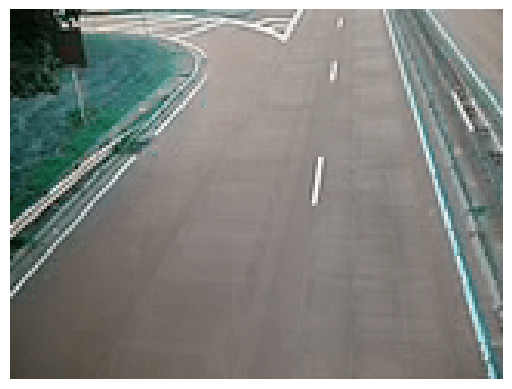

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('background_image_avg.png')

plt.imshow(img)
plt.axis('off')
plt.show()


#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [17]:
!pip install scikit-image


In [18]:
import numpy as np
import imageio

num_frames, height, width, channels = train_frames.shape

pixel_gmms = [[None for _ in range(width)] for _ in range(height)]

components_num = 2

for row in range(height):
    for col in range(width):
        pixel_values = train_frames[:, row, col, :]
        gmm = GMM(n_components=components_num)
        gmm.fit(pixel_values.reshape(-1, channels))
        pixel_gmms[row][col] = gmm

background_model = np.zeros((height, width, channels), dtype=np.float32)
for row in range(height):
    for col in range(width):
        gmm = pixel_gmms[row][col]
        highest_weight_index = np.argmax(gmm.weights)
        background_model[row, col] = gmm.means[highest_weight_index]

background_image = (background_model * 255).astype(np.uint8)
background_image_path = 'background_image.png'
imageio.imwrite(background_image_path, background_image)



In [19]:
import numpy as np
from sklearn.mixture import GaussianMixture
import imageio

num_frames, height, width, channels = train_frames.shape

pixel_gmms = [[None for _ in range(width)] for _ in range(height)]

components_num = 2

for row in range(height):
    for col in range(width):
        pixel_values = train_frames[:, row, col, :]
        gmm = GaussianMixture(n_components=components_num, random_state=0)
        gmm.fit(pixel_values.reshape(-1, channels))

        pixel_gmms[row][col] = gmm

background_model = np.zeros((height, width, channels), dtype=np.float32)
for row in range(height):
    for col in range(width):
        gmm = pixel_gmms[row][col]
        highest_weight_index = np.argmax(gmm.weights_)
        background_model[row, col] = gmm.means_[highest_weight_index]

background_image = (background_model * 255).astype(np.uint8)

background_image_path = 'background_image.png'
imageio.imwrite(background_image_path, background_image)

print(f"Background image saved to {background_image_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


Background image saved to background_image.png


#### Extract Background Image from the trained model

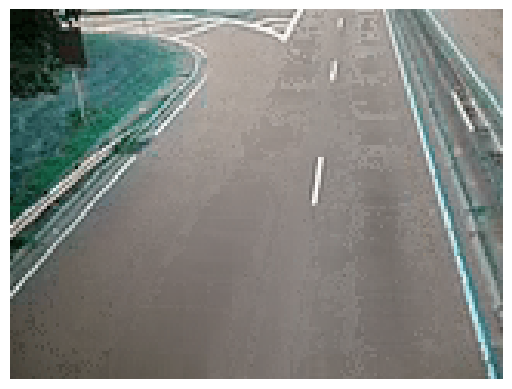

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('background_image.png')

plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()


### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [21]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

#### Frame Averaging

In [22]:
# your output here

In [23]:
import cv2
import numpy as np


foreground_masks = []

threshold_value = 0.2

for frame in test_frames:
    foreground = np.abs(frame - background_image)
    if len(foreground.shape) > 2:
        foreground_gray = cv2.cvtColor((foreground * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        foreground_gray = (foreground * 255).astype(np.uint8)

    _, foreground_mask = cv2.threshold(foreground_gray, threshold_value * 255, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel)

    foreground_masks.append(foreground_mask)



#### GMMs per pixel

In [24]:
import cv2
import numpy as np

foreground_masks = []

threshold_value = 0.43

for frame in test_frames:
    foreground = np.abs(frame - background_image)

    if len(foreground.shape) > 2:
        foreground_gray = cv2.cvtColor((foreground * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        foreground_gray = (foreground * 255).astype(np.uint8)

    _, foreground_mask = cv2.threshold(foreground_gray, threshold_value * 255, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel)
    foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel)

    foreground_masks.append(foreground_mask)



Foreground Mask 0


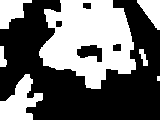

Foreground Mask 1


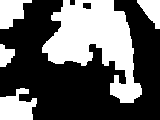

Foreground Mask 2


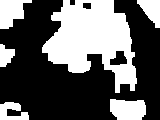

Foreground Mask 3


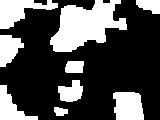

Foreground Mask 4


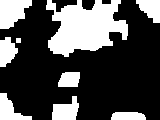

Foreground Mask 5


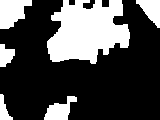

Foreground Mask 6


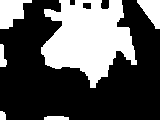

Foreground Mask 7


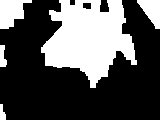

Foreground Mask 8


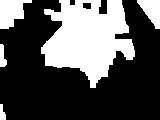

Foreground Mask 9


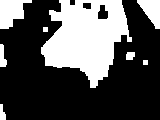

Foreground Mask 10


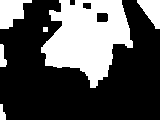

Foreground Mask 11


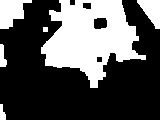

Foreground Mask 12


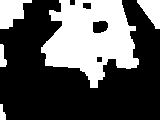

Foreground Mask 13


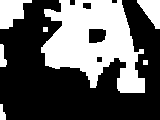

Foreground Mask 14


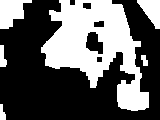

Foreground Mask 15


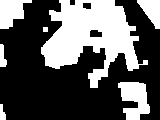

Foreground Mask 16


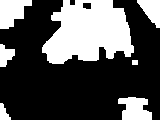

Foreground Mask 17


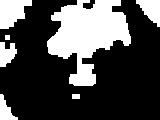

Foreground Mask 18


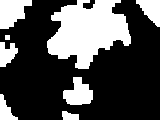

Foreground Mask 19


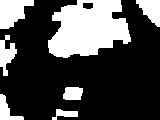

Foreground Mask 20


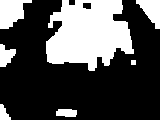

Foreground Mask 21


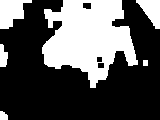

Foreground Mask 22


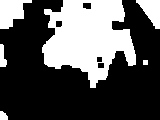

Foreground Mask 23


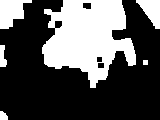

Foreground Mask 24


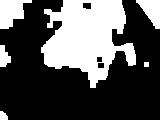

Foreground Mask 25


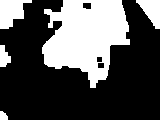

Foreground Mask 26


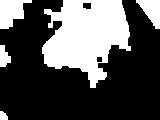

Foreground Mask 27


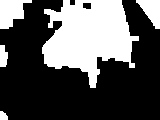

Foreground Mask 28


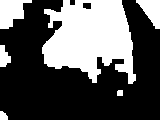

Foreground Mask 29


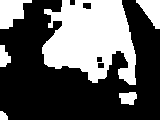

Foreground Mask 30


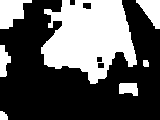

Foreground Mask 31


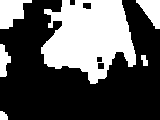

In [25]:
from google.colab.patches import cv2_imshow

for i, mask in enumerate(foreground_masks):
    print(f'Foreground Mask {i}')
    cv2_imshow(mask)


In [26]:
import cv2
import os

frames_dir = 'frames_result'
os.makedirs(frames_dir, exist_ok=True)

for i, mask in enumerate(foreground_masks):
    frame_path = os.path.join(frames_dir, f'foreground_mask_{i}.png')

    cv2.imwrite(frame_path, mask)

    print(f'Saved Foreground Mask {i} at {frame_path}')


Saved Foreground Mask 0 at frames_result/foreground_mask_0.png
Saved Foreground Mask 1 at frames_result/foreground_mask_1.png
Saved Foreground Mask 2 at frames_result/foreground_mask_2.png
Saved Foreground Mask 3 at frames_result/foreground_mask_3.png
Saved Foreground Mask 4 at frames_result/foreground_mask_4.png
Saved Foreground Mask 5 at frames_result/foreground_mask_5.png
Saved Foreground Mask 6 at frames_result/foreground_mask_6.png
Saved Foreground Mask 7 at frames_result/foreground_mask_7.png
Saved Foreground Mask 8 at frames_result/foreground_mask_8.png
Saved Foreground Mask 9 at frames_result/foreground_mask_9.png
Saved Foreground Mask 10 at frames_result/foreground_mask_10.png
Saved Foreground Mask 11 at frames_result/foreground_mask_11.png
Saved Foreground Mask 12 at frames_result/foreground_mask_12.png
Saved Foreground Mask 13 at frames_result/foreground_mask_13.png
Saved Foreground Mask 14 at frames_result/foreground_mask_14.png
Saved Foreground Mask 15 at frames_result/for

In [27]:
!zip -r frames.zip frames
from google.colab import files
files.download('frames.zip')


  adding: frames/ (stored 0%)
  adding: frames/traffic/ (stored 0%)
  adding: frames/traffic/frame_0054.png (deflated 0%)
  adding: frames/traffic/frame_0043.png (deflated 0%)
  adding: frames/traffic/frame_0072.png (deflated 0%)
  adding: frames/traffic/frame_0026.png (deflated 0%)
  adding: frames/traffic/frame_0070.png (deflated 0%)
  adding: frames/traffic/frame_0068.png (deflated 0%)
  adding: frames/traffic/frame_0030.png (deflated 0%)
  adding: frames/traffic/frame_0057.png (deflated 0%)
  adding: frames/traffic/frame_0046.png (deflated 0%)
  adding: frames/traffic/frame_0020.png (deflated 0%)
  adding: frames/traffic/frame_0045.png (deflated 0%)
  adding: frames/traffic/frame_0002.png (deflated 0%)
  adding: frames/traffic/frame_0007.png (deflated 0%)
  adding: frames/traffic/frame_0033.png (deflated 0%)
  adding: frames/traffic/frame_0071.png (deflated 0%)
  adding: frames/traffic/frame_0074.png (deflated 0%)
  adding: frames/traffic/frame_0062.png (deflated 0%)
  adding: fram

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import cv2
import os
import numpy as np
from google.colab import files

def save_frames_colab(frames, fps=10.0, output_path='./', file_name='foreground'):
    """
    Save the frames as a video in Google Colab.
    """
    eps = 0.0001

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    save_path = os.path.join(output_path, f"{file_name}.mp4")
    vid_writer = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size, isColor=True)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        vid_writer.write(frame_bgr)

    vid_writer.release()

    return save_path


foreground_frames = [np.stack((mask,)*3, axis=-1) for mask in foreground_masks]

video_save_path = save_frames_colab(foreground_frames, fps=10.0, file_name='foreground_objects')

files.download(video_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>